In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
import wave
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
from scipy import signal
from scipy.optimize import curve_fit 
from functools import wraps

# ディレクトリの絶対パスを取得
current_dir = os.path.dirname(os.path.abspath("__file__"))
# モジュールのあるパスを追加
sys.path.append( str(current_dir) + '/../../research_tools' )

get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline

plt.rcParams['font.family'] ='IPAPGothic' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.top'] = True #x軸の目盛線の上側を表示
plt.rcParams['ytick.right'] = True #y軸の目盛線の右側を表示
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 11 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['figure.dpi'] = 100 #dpiの設定
plt.rcParams['figure.subplot.hspace'] = 0.3 # 図と図の幅
plt.rcParams['figure.subplot.wspace'] = 0.3 # 図と図の幅

fig = plt.figure(figsize=(8, 11))

<Figure size 800x1100 with 0 Axes>

In [2]:
try:
    import decorators
    import plot_tool
    import plot_tools
    import adaptive_filters
    import wave_process
except ModuleNotFoundError as err:
    print(err)
    sys.path.append( str(current_dir) + '/programs' )
    print(sys.path)
    print("Add path : ./programs")
    import decorators
    import plot_tool
    import plot_tools
    import adaptive_filters
    import wave_process

Window Not Found


In [3]:
d_size = 128

# Make desired value
# d=array(sin(t)) #sine wave
d = np.random.rand(8888, 1)

###############  START  ###############


/Users/tetsu/personal_files/Research/filters/test/../../research_tools/adaptive_filters.py:69: UserWarning: the data was not divisible by adf_N, the last part was truncated.               original sample : 8888 > 8832 : truncated sample
  original sample : {len(d)} > {sample_len} : truncated sample")


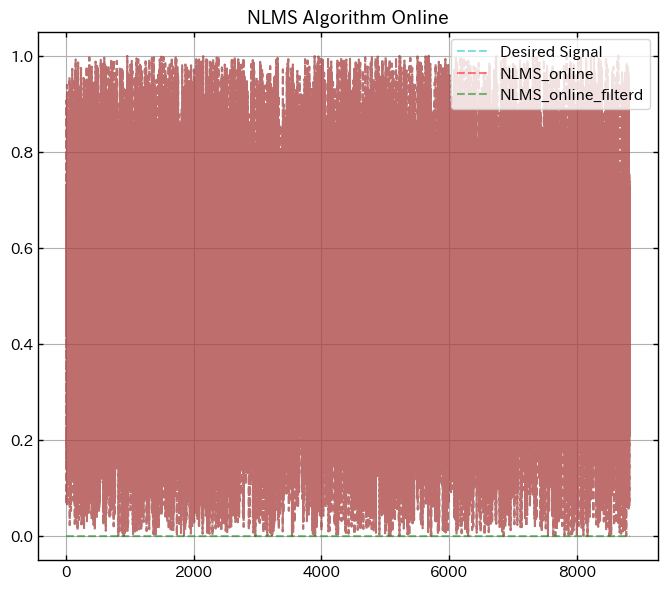

###############  END  ###############
2.37448[sec] elapsed to execute the function:nlms_agm_on


In [4]:
ADF_out = decorators.stop_watch(adaptive_filters.nlms_agm_on)(
                                    alpha=1.3, update_count=20, threshold=0.0000001, d=d, adf_N=d_size)

In [5]:
d_1d = d.reshape(len(d),)
d_1d = (d_1d - np.mean(d_1d))
d_1d_std = np.std(d_1d)
print(d_1d_std)
ADF_out_1d = ADF_out.reshape(len(ADF_out),)
ADF_out_1d = (ADF_out_1d - np.mean(ADF_out_1d))
ADF_out_1d_std = np.std(ADF_out_1d)
print(ADF_out_1d_std)

0.2880304227291909
0.2880970447872111


In [6]:
d_1d = d_1d / (d_1d_std * len(d_1d))

In [7]:
ADF_out_1d = ADF_out_1d / ADF_out_1d_std

In [8]:
corr = np.correlate(d_1d, ADF_out_1d, "full")

In [9]:
corr_gragh = plot_tools.PlotTools(y=corr, fs=48000, fft_N=len(corr), stft_N=128, window="rectangular")

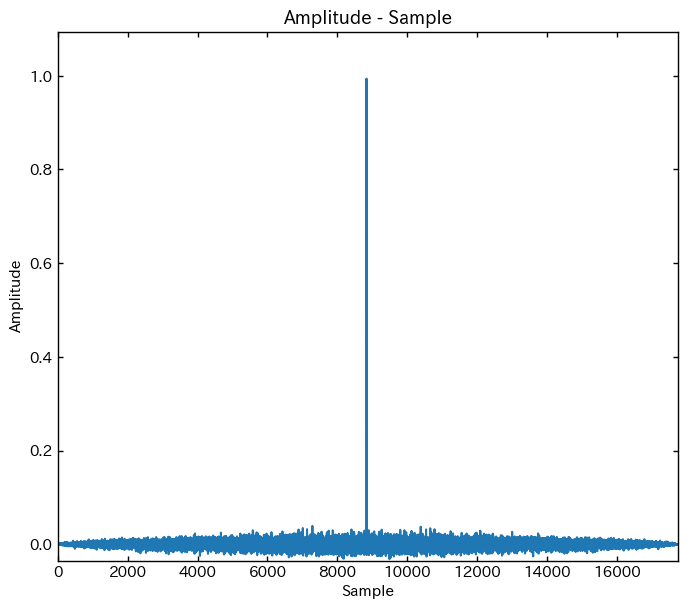

In [10]:
corr_gragh.plot_y_sample()

## 加工前の音声

In [11]:
wav = wave_process.wave_process("../../sample_wav/fukushima.wav")

分析対象ファイル： ../../sample_wav/fukushima.wav
チャンクサイズ： 3098892
サンプルサイズのバイト数： 2
チャンネル数： 1
wavファイルのサンプリング周波数： 48000
パラメータ :  _wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=3098892, comptype='NONE', compname='not compressed')
wavファイルのデータ個数： 3098892


In [12]:
wav_row = plot_tools.PlotTools(y=wav.data[:524288], fft_N=524288, stft_N=256, fs=wav.fs, window="hamming")

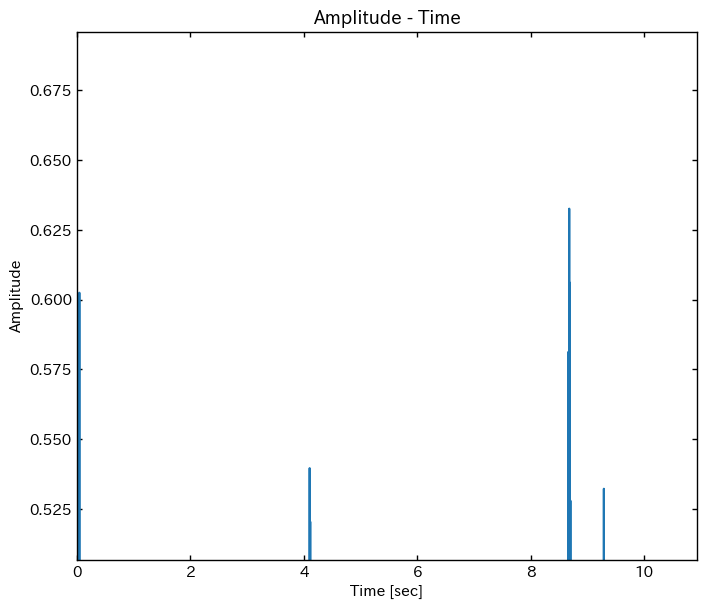

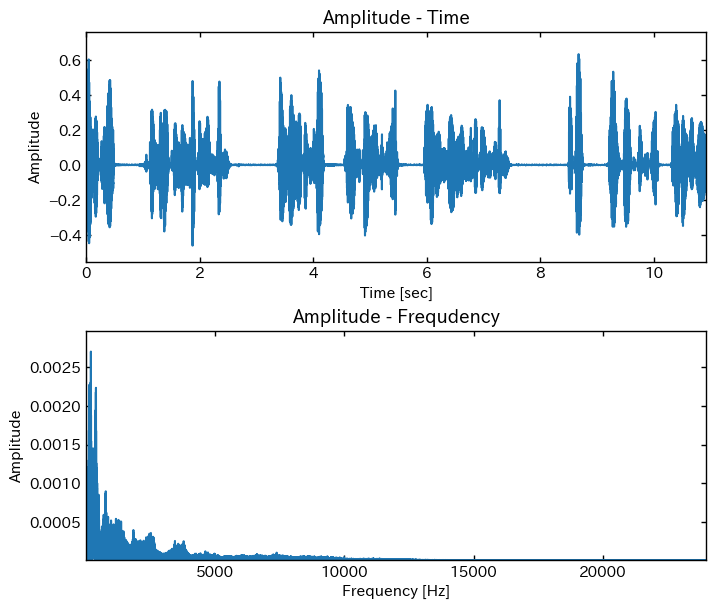

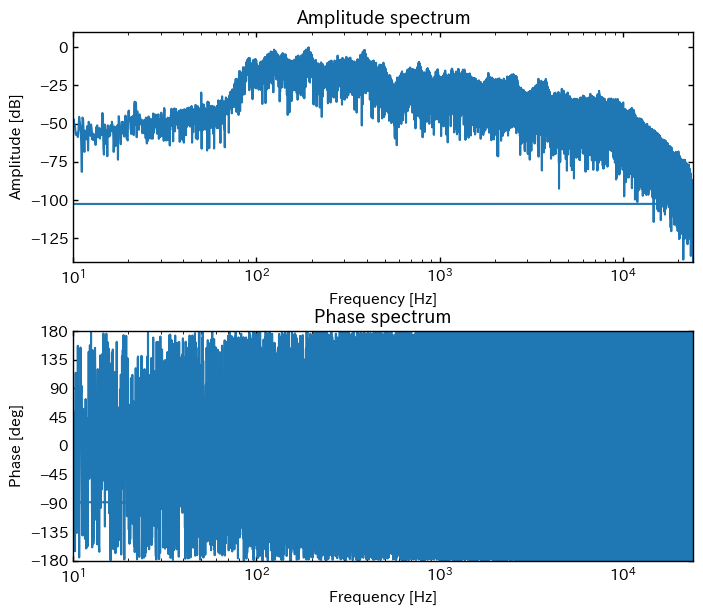

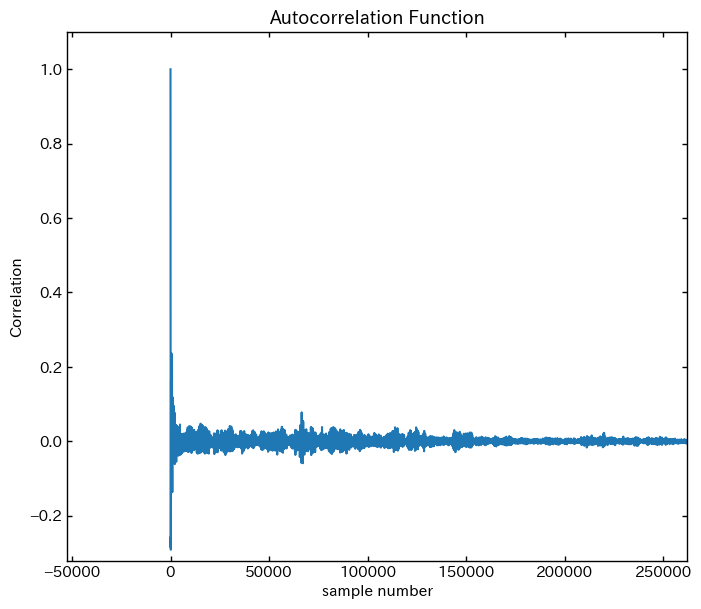

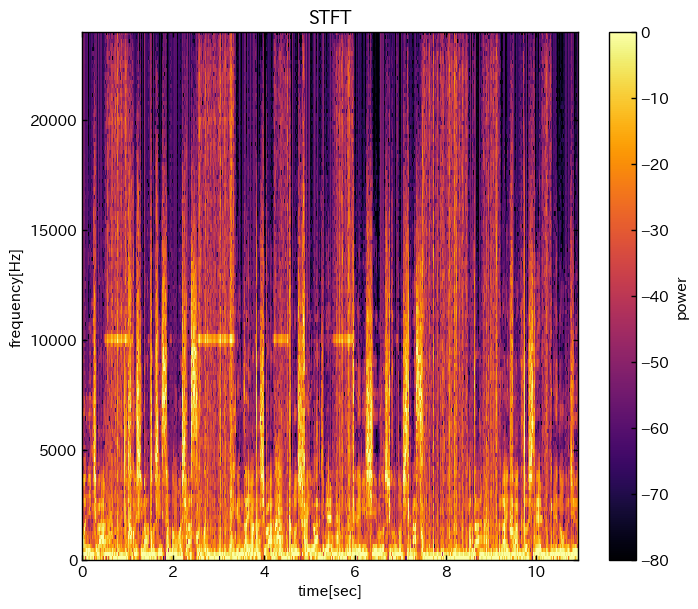

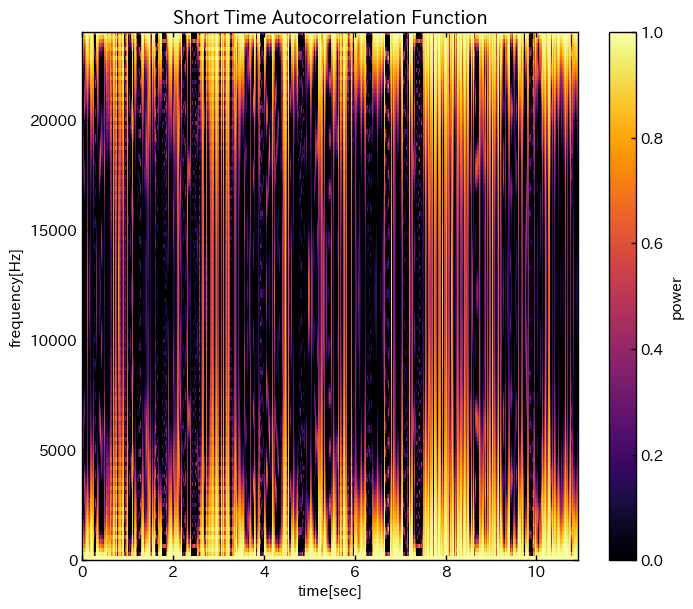

In [13]:
wav_row.plot_all()

In [40]:
N = 2**19  # サンプル数 528244
fs = wav.fs
dt = 1/fs            # サンプリング周期 [s]
f1, f2, f3 = 100, 1000, 3000 # 周波数 [Hz]

t = np.arange(0, N*dt, dt) # 時間 [s]
# wav_noise = wav.data[:N] + 0.3 * np.sin(2*np.pi*f2*t)
noise = 0.1 * np.random.rand(N)
noise = (noise - np.mean(noise)) * 2
#noise = (noise - 0.5) * 2
wav_noise = wav.data[:N] + noise

In [41]:
wav.wave_write(filename="../../sample_wav/fuku_white_noise.wav", data_array=wav_noise)

In [42]:
wav_noise_gragh = plot_tools.PlotTools(y=wav_noise, fs=fs, fft_N=N, window="hamming")

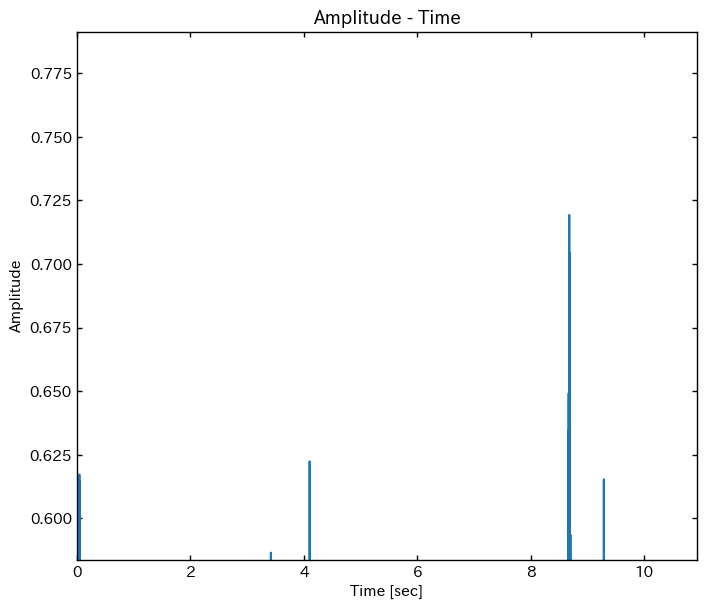

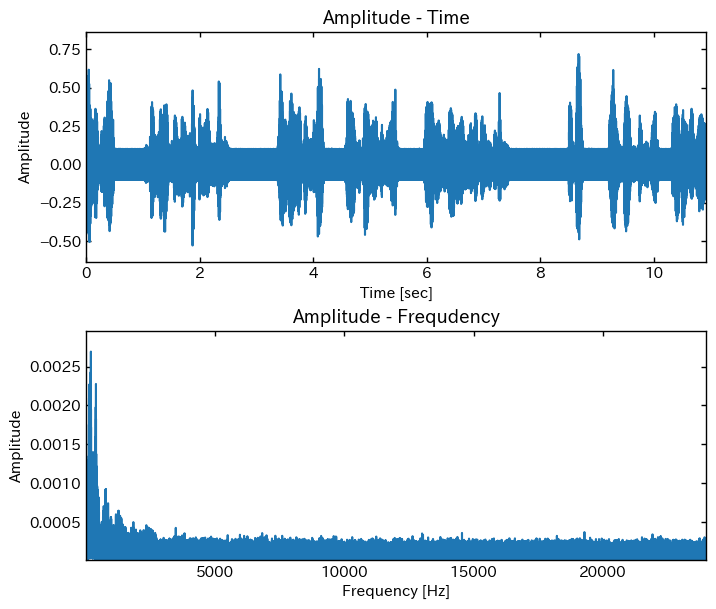

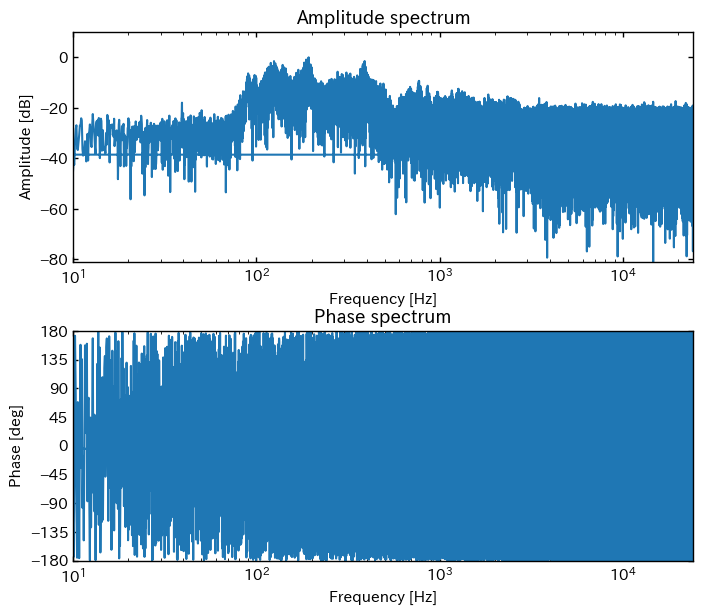

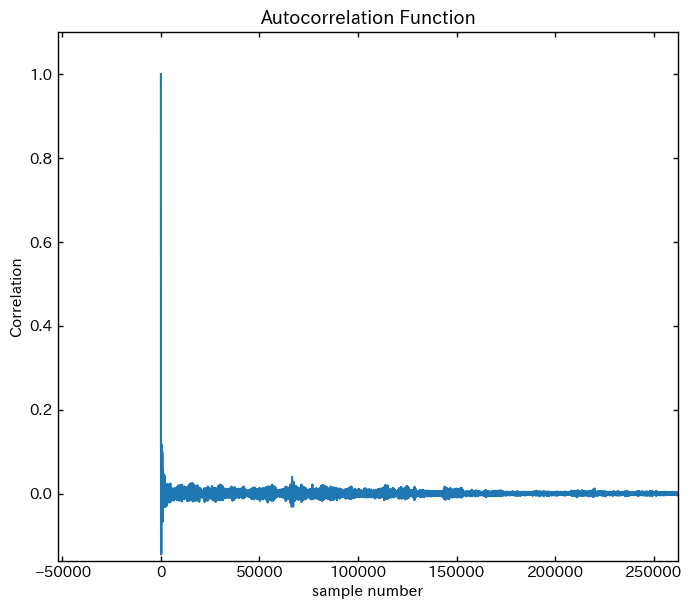

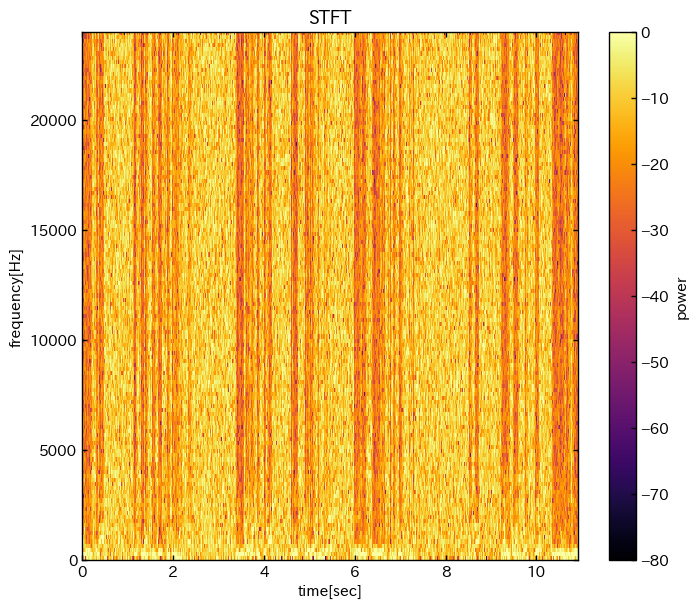

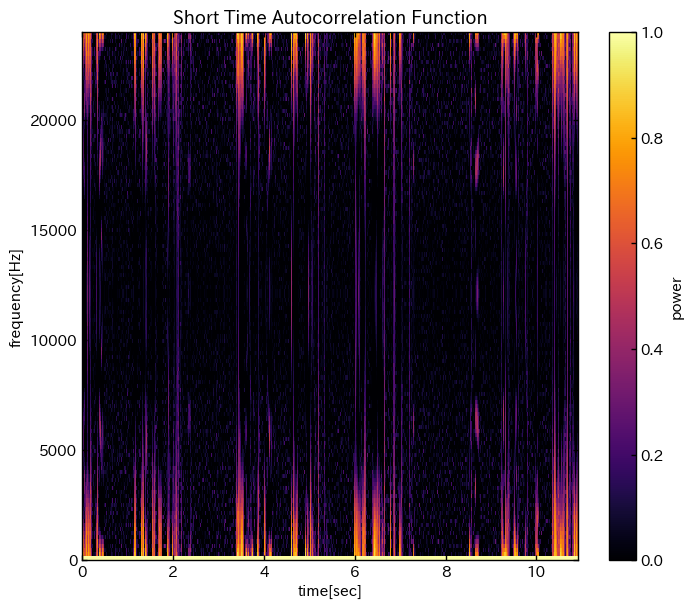

In [43]:
wav_noise_gragh.plot_all()

# NLMS 適応

In [44]:
wav_noise = np.array(wav_noise).reshape(len(wav_noise),1)

###############  START  ###############


/Users/tetsu/personal_files/Research/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


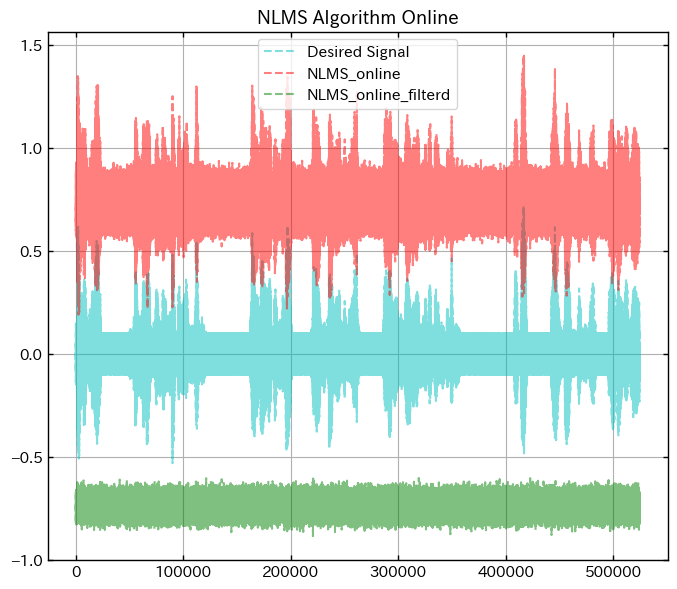

###############  END  ###############
113.49457[sec] elapsed to execute the function:nlms_agm_on


In [45]:
adf_N = 256
ADF_out = decorators.stop_watch(
                                adaptive_filters.nlms_agm_on)(
                                    alpha=0.2, update_count=20, threshold=0.8, d=wav_noise, adf_N=adf_N)


In [46]:
adapted_signal = wav_noise - ADF_out

In [47]:
wav.wave_write(filename="../../sample_wav/fuku_nlms.wav", data_array=adapted_signal)

In [48]:
inv_adapted = wav_noise - adapted_signal
inv_adapted = inv_adapted.reshape(len(inv_adapted,))

In [49]:
inv_adapted_graph = plot_tools.PlotTools(y=inv_adapted, fs=fs, fft_N=len(inv_adapted), stft_N=256, window="hamming")

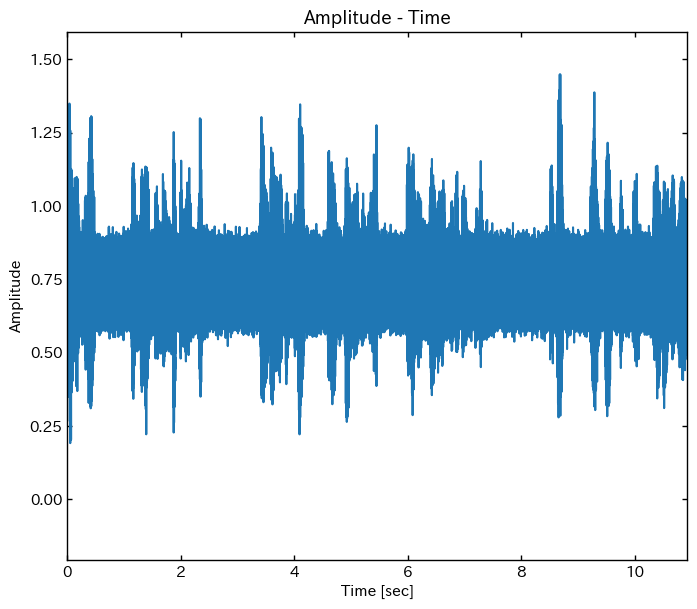

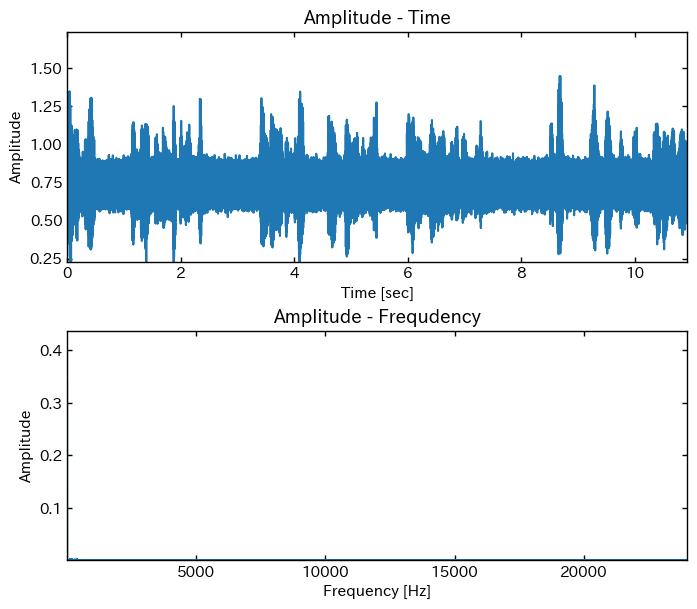

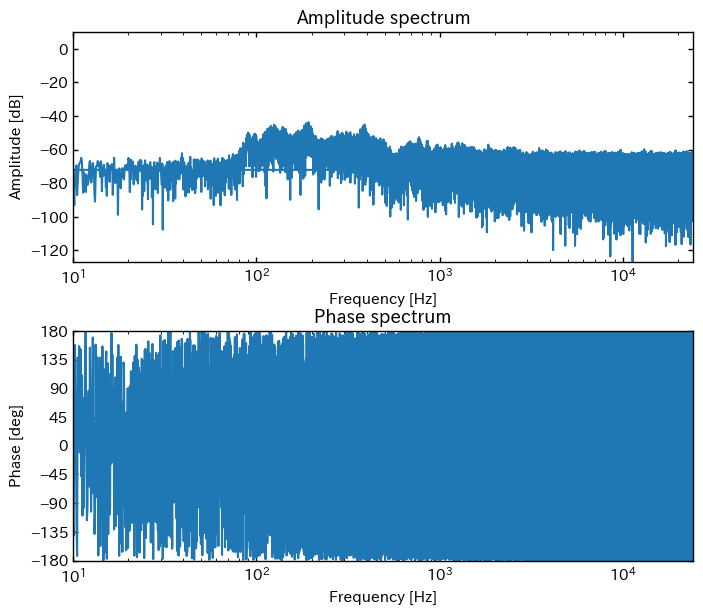

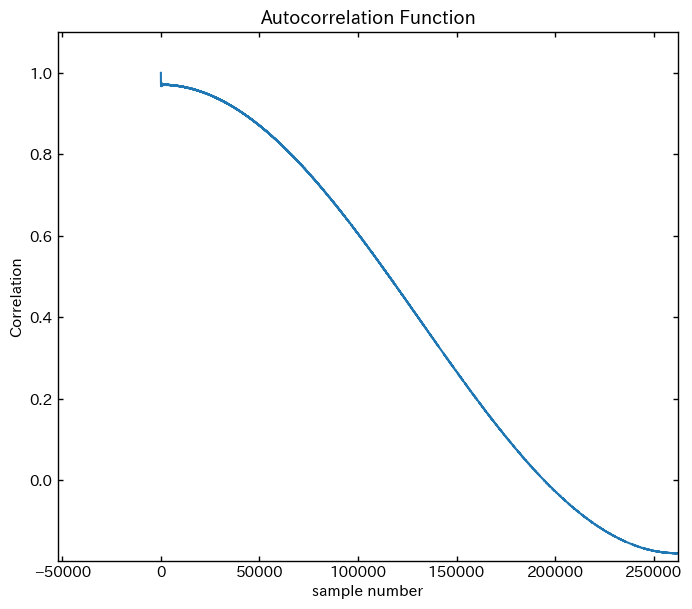

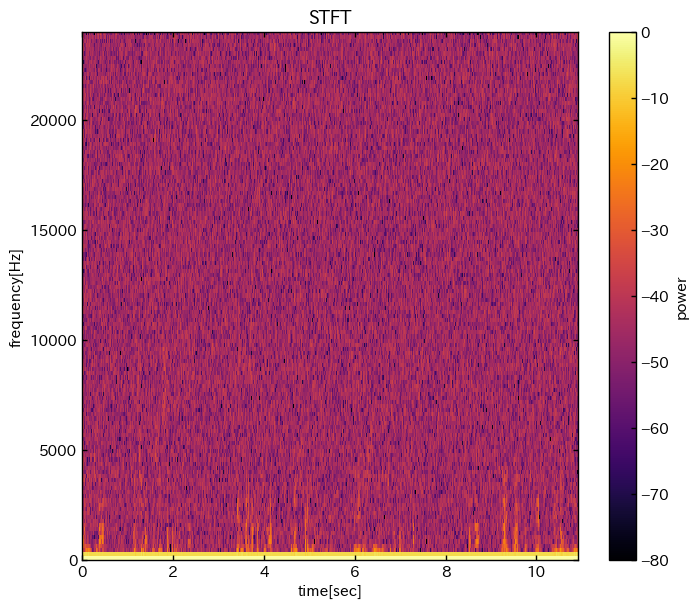

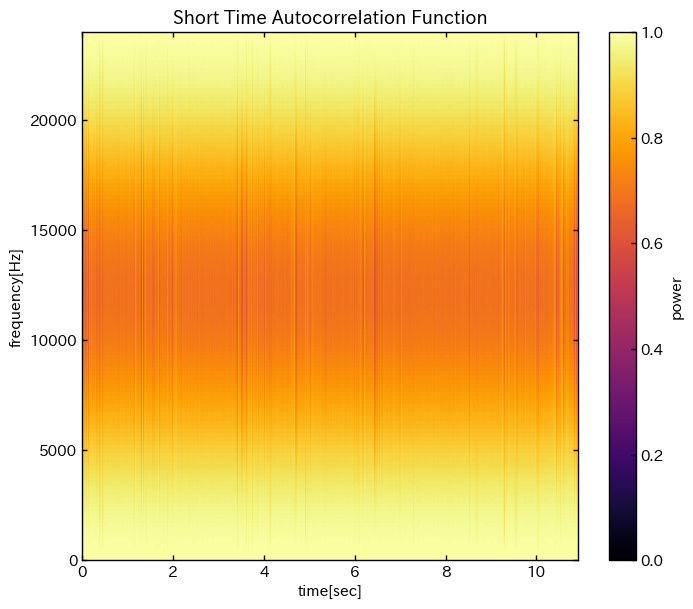

In [50]:
inv_adapted_graph.plot_all()

In [ ]:
adf_N = 65536
ADF_out = decorators.stop_watch(
                                adaptive_filters.nlms_agm_on)(
                                    alpha=0.2, update_count=20, threshold=0.8, d=wav_noise, adf_N=adf_N)

###############  START  ###############


In [ ]:
d_1d = wav_noise.reshape(len(wav_noise),)
d_1d = (d_1d - np.mean(d_1d))
d_1d_std = np.std(d_1d)
print(d_1d_std)
ADF_out_1d = ADF_out.reshape(len(ADF_out),)
ADF_out_1d = (ADF_out_1d - np.mean(ADF_out_1d))
ADF_out_1d_std = np.std(ADF_out_1d)
print(ADF_out_1d_std)

d_1d = d_1d / (d_1d_std * len(d_1d))
ADF_out_1d = ADF_out_1d / ADF_out_1d_std

corr = np.correlate(d_1d, ADF_out_1d, "full")
corr_gragh = plot_tools.PlotTools(y=corr, fs=wav.fs, fft_N=len(corr), stft_N=128, window="rectangular")
corr_gragh.plot_y_sample()